# Train/fine-tune computer vision (CV) classifiers

In this notebook, we use the annotated images (see, e.g., notebooks `001` and `002`) to train/fine-tune CV classifiers.

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# from mapreader import classifier
# from mapreader import loadAnnotations
# from mapreader import patchTorchDataset
# 
# import numpy as np
# import torch
# from torch import nn
# import torchvision
# from torchvision import transforms
# from torchvision import models

## Read annotations

In [4]:
from mapreader import loadAnnotations

In [5]:
annotated_images = loadAnnotations()

In [6]:
annotated_images.load("./annotations_one_inch/rail_space_#rw#.csv", 
                      path2dir="./maps/slice_50_50")

* reading: ./annotations_one_inch/rail_space_#rw#.csv
* #rows: 298
* label column name: label (you can change this later by .set_col_label(new_label) )
* shuffle rows: Yes
* update paths in 'image_id' column by inserting './maps/slice_50_50'

------------------------
* Number of annotations: 298

* First few rows:
                                            image_id  label
0  /Users/rwood/LwM/MapReader/examples/geospatial...      1
1  /Users/rwood/LwM/MapReader/examples/geospatial...      1
2  /Users/rwood/LwM/MapReader/examples/geospatial...      1
3  /Users/rwood/LwM/MapReader/examples/geospatial...      1
4  /Users/rwood/LwM/MapReader/examples/geospatial...      1
...

* Value counts (column: label):
1    278
2     20
Name: label, dtype: int64
------------------------



In [7]:
annotated_images.annotations

,image_id,label
0,/Users/rwood/LwM/MapReader/examples/geospatial...,1
1,/Users/rwood/LwM/MapReader/examples/geospatial...,1
2,/Users/rwood/LwM/MapReader/examples/geospatial...,1
3,/Users/rwood/LwM/MapReader/examples/geospatial...,1
4,/Users/rwood/LwM/MapReader/examples/geospatial...,1
...,...,...
293,/Users/rwood/LwM/MapReader/examples/geospatial...,1
294,/Users/rwood/LwM/MapReader/examples/geospatial...,1
295,/Users/rwood/LwM/MapReader/examples/geospatial...,1
296,/Users/rwood/LwM/MapReader/examples/geospatial...,1


In [8]:
print(annotated_images)

------------------------
* Number of annotations: 298

* First few rows:
                                            image_id  label
0  /Users/rwood/LwM/MapReader/examples/geospatial...      1
1  /Users/rwood/LwM/MapReader/examples/geospatial...      1
2  /Users/rwood/LwM/MapReader/examples/geospatial...      1
3  /Users/rwood/LwM/MapReader/examples/geospatial...      1
4  /Users/rwood/LwM/MapReader/examples/geospatial...      1
...

* Value counts (column: label):
1    278
2     20
Name: label, dtype: int64
------------------------



In [9]:
# We need to shift these labels so that they start from 0:
annotated_images.adjust_labels(shiftby=-1)

--------------------
[INFO] value counts before shift:
1    278
2     20
Name: label, dtype: int64
--------------------
[INFO] value counts after shift:
0    278
1     20
Name: label, dtype: int64
--------------------


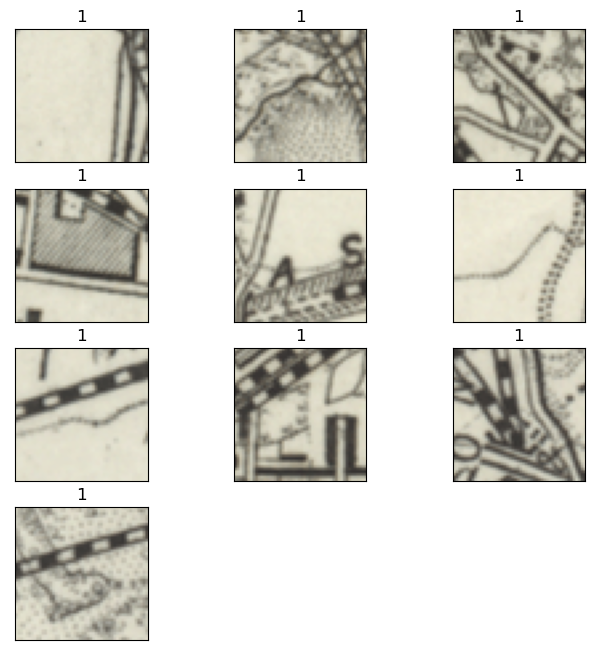

In [11]:
# show sample images for target label (tar_label)
annotated_images.show_image_labels(tar_label=1)

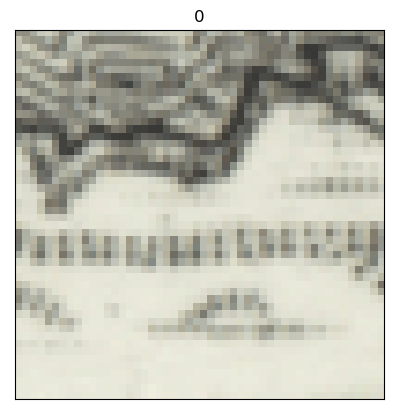

In [12]:
# show an image based on its index 
annotated_images.show_image(indx=14)

### Split annotations into train/val or train/val/test

We use a stratified method for splitting the annotations, that is, each set contains approximately the same percentage of samples of each target label as the original set.

In [13]:
annotated_images.split_annotations()

---------------------
* Split dataset into:
    Train: 208
    Valid: 45
    Test : 45
---------------------


In [14]:
annotated_images.split_annotations(frac_train=0.7, 
                                   frac_val=0.15, 
                                   frac_test=0.15)

---------------------
* Split dataset into:
    Train: 208
    Valid: 45
    Test : 45
---------------------


Dataframes for train, validation and test sets can be accessed via:

```python
annotated_images.train
annotated_images.val
annotated_images.test
```

In [15]:
annotated_images.train["label"].value_counts()

0    194
1     14
Name: label, dtype: int64

In [16]:
annotated_images.val["label"].value_counts()

0    42
1     3
Name: label, dtype: int64

In [17]:
annotated_images.test["label"].value_counts()

0    42
1     3
Name: label, dtype: int64

# Classifier

## Dataset

Define transformations to be applied to images before being used in training or validation/inference.

`patchTorchDataset` has some default transformations. However, it is possible to define your own transformations and pass them to `patchTorchDataset`:

In [21]:
from mapreader import patchTorchDataset

In [18]:
from torchvision import transforms

In [81]:
# ------------------
# --- Transformation
# ------------------ 

# FOR INCEPTION
#resize2 = 299
# otherwise:
resize2 = 224

# mean and standard deviations of pixel intensities in 
# all the patches in 6", second edition maps
#normalize_mean = 1 - np.array([0.82860442, 0.82515008, 0.77019864])
#normalize_std = 1 - np.array([0.1025585, 0.10527616, 0.10039222])
# other options:
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose(
        [transforms.Resize(resize2),
             transforms.RandomApply([
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.RandomVerticalFlip(p=0.5),
             ], p=0.5),
         transforms.RandomApply([
             transforms.GaussianBlur(21, sigma=(0.5, 5.0)),
             ], p=0.25),
         transforms.RandomApply([
             #transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
             transforms.Resize((50, 50)),
             ], p=0.25),
#         transforms.RandomApply([
#            transforms.RandomAffine(180, translate=None, scale=None, shear=20),
#            ], p=0.25),
         transforms.Resize(resize2),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
        ]),
    'val': transforms.Compose(
        [transforms.Resize(resize2),
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
        ]),
}


Now, we can use these transformations to instantiate `patchTorchDataset`:

In [82]:
train_dataset = patchTorchDataset(annotated_images.train, 
                                  transform=data_transforms['train'])
val_dataset = patchTorchDataset(annotated_images.val,   
                                  transform=data_transforms['val'])
test_dataset  = patchTorchDataset(annotated_images.test,  
                                  transform=data_transforms['val'])

## Sampler

In [24]:
    import numpy as np
    import torch

In [83]:
# -----------
# --- Sampler
# -----------
# We define a sampler as we have a highly imbalanced dataset
train_label_count = train_dataset.patchframe["label"].value_counts().to_list()
val_label_count = val_dataset.patchframe["label"].value_counts().to_list()


weights = np.reciprocal(torch.Tensor(train_label_count))
weights = weights.double()
print(f"Weights: {weights}")

Weights: tensor([0.0052, 0.0714], dtype=torch.float64)


In [85]:
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[train_dataset.patchframe["label"].to_list()], 
    num_samples=len(train_dataset.patchframe))

valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights[val_dataset.patchframe["label"].to_list()], 
    num_samples=len(val_dataset.patchframe))


## Dataloader

In [31]:
from mapreader import classifier

In [86]:
my_classifier = classifier(device = 'cuda:0' if torch.cuda.is_available() else 'cpu')

[INFO] Device is set to cpu


In [87]:
batch_size = 8

# Add training dataset
my_classifier.add2dataloader(train_dataset, 
                            set_name="train", 
                            batch_size=batch_size, 
                            # shuffle can be False as annotations have already been shuffled
                            shuffle=False,
                            num_workers=0,
                            sampler=train_sampler
                           )

# Add validation dataset
my_classifier.add2dataloader(val_dataset, 
                            set_name="val", 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=0,
                            #sampler=valid_sampler
                           )

[INFO] added 'train' dataloader with 208 elements.
[INFO] added 'val' dataloader with 45 elements.


In [88]:
my_classifier.dataset_sizes

{'train': 208, 'val': 45}

In [46]:
my_classifier.print_classes_dl('train')
my_classifier.print_classes_dl('val')

[INFO] labels:      [0, 1]
[INFO] labels:      [0, 1]


In [89]:
# set class names for plots
class_names = {0: "No", 
               1: "rail space"}
my_classifier.set_classnames(class_names)

In [56]:
my_classifier.print_classes_dl()

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'rail space'}


In [140]:
my_classifier.batch_info()

[INFO] dataset: train
#samples:    208
#batch size: 8
#batches:    26


[INFO] dataset: train
#samples:    208
#batch size: 8
#batches:    26


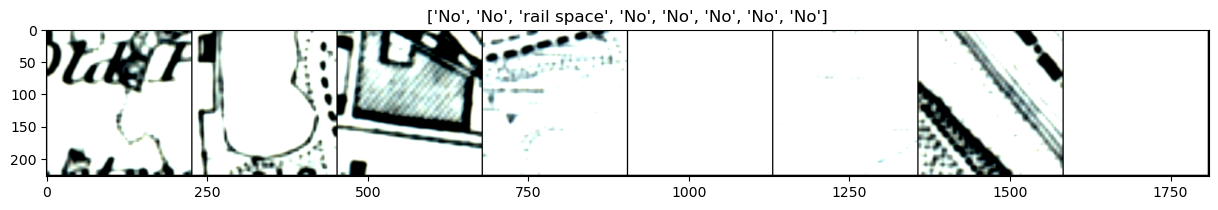

In [143]:
my_classifier.show_sample(set_name='val', batch_number=3)

[INFO] dataset: train
#samples:    208
#batch size: 8
#batches:    26


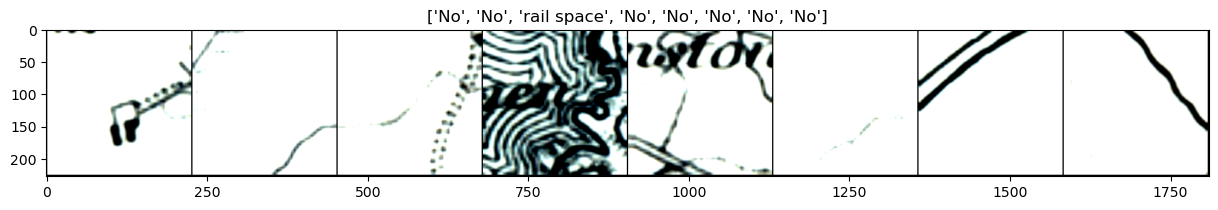

[INFO] dataset: train
#samples:    208
#batch size: 8
#batches:    26


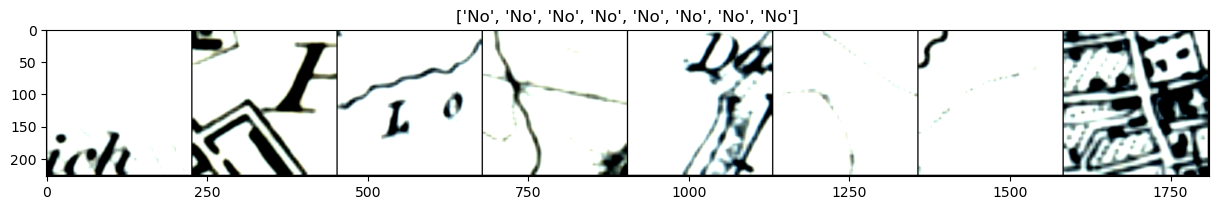

[INFO] dataset: train
#samples:    208
#batch size: 8
#batches:    26


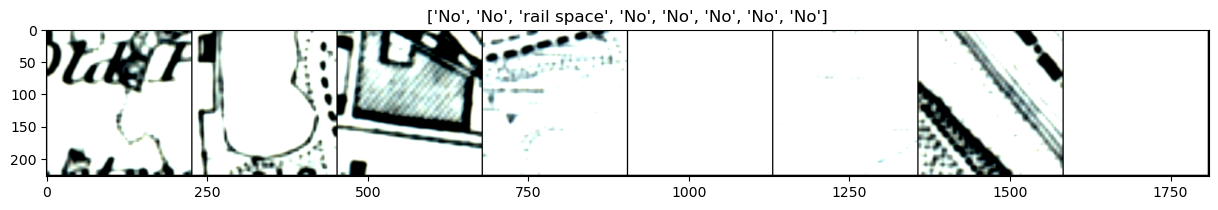

In [96]:
for bn in range(1, 4):
    my_classifier.show_sample(set_name="val", 
                             batch_number=bn)

## Load a (pretrained) PyTorch model and add it to `classifier`

Two methods to add a (pretrained) PyTorch model:
1. Define a model using `from torchvision import models`
2. Use `.initialize_model` method

### Method 1: Define a model using `from torchvision import models`

In [147]:
from torchvision import models
from torch import nn

In [206]:
my_model=models.resnet18(pretrained=True)

In [151]:
# # Choose a model from the supported PyTorch models
model_ft = models.resnet18(pretrained=True)

# # Add FC based on the number of classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, my_classifier.num_classes)

# # Add the model to myclassifier
my_classifier.add_model(model_ft)

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'rail space'}


In [152]:
my_classifier.model_summary()

------------------------------------------------------------------------------------------
|                                  modules |           parameters |                  dim
------------------------------------------------------------------------------------------
|                             conv1.weight |                 9408 |        [64, 3, 7, 7] |
|                               bn1.weight |                   64 |                 [64] |
|                                 bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv1.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn1.weight |                   64 |                 [64] |
|                        layer1.0.bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv2.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn2.weight |                   64 |                 [64] |
|

### Method 2: use `.initialize_model`

In [207]:
my_classifier.del_model()

In [208]:
my_classifier.initialize_model("resnet18")

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'rail space'}


In [209]:
my_classifier.model_summary()

------------------------------------------------------------------------------------------
|                                  modules |           parameters |                  dim
------------------------------------------------------------------------------------------
|                             conv1.weight |                 9408 |        [64, 3, 7, 7] |
|                               bn1.weight |                   64 |                 [64] |
|                                 bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv1.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn1.weight |                   64 |                 [64] |
|                        layer1.0.bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv2.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn2.weight |                   64 |                 [64] |
|

In [210]:
my_classifier.initialize_model("resnet18", 
                              pretrained=True, 
                              last_layer_num_classes="default",
                              add_model=True)

[INFO] labels:      [0, 1]
[INFO] class-names: {0: 'No', 1: 'rail space'}


In [211]:
my_classifier.model_summary(only_trainable=False)

------------------------------------------------------------------------------------------
|                                  modules |           parameters |                  dim
------------------------------------------------------------------------------------------
|                             conv1.weight |                 9408 |        [64, 3, 7, 7] |
|                               bn1.weight |                   64 |                 [64] |
|                                 bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv1.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn1.weight |                   64 |                 [64] |
|                        layer1.0.bn1.bias |                   64 |                 [64] |
|                    layer1.0.conv2.weight |                36864 |       [64, 64, 3, 3] |
|                      layer1.0.bn2.weight |                   64 |                 [64] |
|

## (Un)freeze layers in the neural network architecture

In [51]:
# myclassifier.freeze_layers(["conv1.weight", "bn1.weight", "bn1.bias", "layer1*", "layer2*", "layer3*"])
# myclassifier.model_summary(only_trainable=False)

In [52]:
# myclassifier.unfreeze_layers(["layer3*"])
# myclassifier.model_summary(only_trainable=False)

In [53]:
# myclassifier.only_keep_layers(["fc.weight", "fc.bias"])
# myclassifier.model_summary(only_trainable=True)

## Define optimizer, scheduler and criterion

We can either use one learning rate for all the layers in the neural network or define layerwise learning rates, that is, the learning rate of each layer is different. This is normally used in fine-tuning pretrained models in which a smaller learning rate is assigned to the first layers.

`MapReader` has a `.layerwise_lr` method to define layerwise learning rates. By default, `MapReader` uses a linear function to distribute the learning rates (using `min_lr` for the first layer and `max_lr` for the last layer). The linear function can be changed using `ltype="geomspace"` argument.

In [212]:
list2optim = my_classifier.layerwise_lr(min_lr=1e-4, max_lr=1e-3, ltype="geomspace")

In [213]:
my_classifier.initialize_optimizer(params2optim=list2optim)

In [214]:
optim_param_dict = {
    "lr": 1e-3,
    "betas": (0.9, 0.999), 
    "eps": 1e-08, 
    "weight_decay": 0, 
    "amsgrad": False
}

# --- if list2optim is defined, e.g., by using `.layerwise_lr` method (see the previous cell):
my_classifier.initialize_optimizer(optim_type="adam", 
                                  params2optim=list2optim,
                                  optim_param_dict=optim_param_dict,
                                  add_optim=True)

# --- otherwise:
# myclassifier.initialize_optimizer(optim_type="adam", 
#                                   optim_param_dict=optim_param_dict,
#                                   add_optim=True)

Other optimizers can also be used in the above cell, e.g.:

```python
optim_param_dict = {
    "lr": 1e-3, 
    "momentum": 0, 
    "dampening": 0, 
    "weight_decay": 0, 
    "nesterov": False
}

myclassifier.initialize_optimizer(optim_type="sgd", 
                                  optim_param_dict=optim_param_dict,
                                  add_optim=True)
```

In [215]:
scheduler_param_dict = {
    "step_size": 10, 
    "gamma": 0.1, 
    "last_epoch": -1, 
    "verbose": False
}

my_classifier.initialize_scheduler(scheduler_type="steplr",
                                  scheduler_param_dict=scheduler_param_dict,
                                  add_scheduler=True)

Other schedulers can also be used in the above cell, e.g.:

```python
scheduler_param_dict = {
    "max_lr": 1e-2, 
    "steps_per_epoch": len(myclassifier.dataloader["train"]), 
    "epochs": 5
}

myclassifier.initialize_scheduler(scheduler_type="OneCycleLR",
                                  scheduler_param_dict=scheduler_param_dict,
                                  add_scheduler=True)
```

In [216]:
from torch import nn

# Add criterion
criterion = nn.CrossEntropyLoss()

my_classifier.add_criterion(criterion)

## Train/fine-tune a model

**Note:** it is possible to interrupt a training (using Kernel/Interrupt in Jupyter Notebook or ctrl+C). 

In [226]:
my_classifier.train(num_epochs=10, 
                   save_model_dir="./models_tutorial", 
                   tensorboard_path="tboard_tutorial", 
                   verbosity_level=0,
                   tmp_file_save_freq=2,
                   remove_after_load=False,
                   print_info_batch_freq=5)

2023-02-07 14:28:49 JY5FK6W3K5 [INFO] train    -- 11/20 --       8/208 (  3.8%) -- Loss: 0.350
2023-02-07 14:28:50 JY5FK6W3K5 [INFO] train    -- 11/20 --      48/208 ( 23.1%) -- Loss: 0.318
2023-02-07 14:28:52 JY5FK6W3K5 [INFO] train    -- 11/20 --      88/208 ( 42.3%) -- Loss: 0.649
2023-02-07 14:28:53 JY5FK6W3K5 [INFO] train    -- 11/20 --     128/208 ( 61.5%) -- Loss: 0.211
2023-02-07 14:28:55 JY5FK6W3K5 [INFO] train    -- 11/20 --     168/208 ( 80.8%) -- Loss: 0.167
2023-02-07 14:28:56 JY5FK6W3K5 [INFO] train    -- 11/20 --     208/208 (100.0%) -- Loss: 0.061
2023-02-07 14:28:56 JY5FK6W3K5 [INFO] train    -- 11/20 -- Loss: 0.309; F_macro: 86.05; R_macro: 86.37
2023-02-07 14:28:56 JY5FK6W3K5 [INFO] val      -- 11/20 --        8/45 ( 17.8%) -- Loss: 0.597
2023-02-07 14:28:57 JY5FK6W3K5 [INFO] val      -- 11/20 --       45/45 (100.0%) -- Loss: 0.022
2023-02-07 14:28:57 JY5FK6W3K5 [INFO] val      -- 11/20 -- Loss: 0.210; F_macro: 73.84; R_macro: 66.67

2023-02-07 14:28:57 JY5FK6W3K5 [I

2023-02-07 14:29:40 JY5FK6W3K5 [INFO] val      -- 16/20 --       45/45 (100.0%) -- Loss: 0.002
2023-02-07 14:29:40 JY5FK6W3K5 [INFO] val      -- 16/20 -- Loss: 0.285; F_macro: 68.24; R_macro: 65.48

SAVE temp file: tmp_6753750616_checkpoint.pkl | set .last_epoch: 16
[INFO] SAVE temp file: tmp_6753750616_checkpoint.pkl | set .last_epoch: 16

2023-02-07 14:29:40 JY5FK6W3K5 [INFO] train    -- 17/20 --       8/208 (  3.8%) -- Loss: 0.037
2023-02-07 14:29:42 JY5FK6W3K5 [INFO] train    -- 17/20 --      48/208 ( 23.1%) -- Loss: 0.082
2023-02-07 14:29:44 JY5FK6W3K5 [INFO] train    -- 17/20 --      88/208 ( 42.3%) -- Loss: 0.178
2023-02-07 14:29:45 JY5FK6W3K5 [INFO] train    -- 17/20 --     128/208 ( 61.5%) -- Loss: 0.035
2023-02-07 14:29:47 JY5FK6W3K5 [INFO] train    -- 17/20 --     168/208 ( 80.8%) -- Loss: 0.045
2023-02-07 14:29:48 JY5FK6W3K5 [INFO] train    -- 17/20 --     208/208 (100.0%) -- Loss: 0.038
2023-02-07 14:29:48 JY5FK6W3K5 [INFO] train    -- 17/20 -- Loss: 0.078; F_macro: 96.59;

### Plot results

In [198]:
my_classifier.metrics

{'epoch_loss_train': [0.8726609980400938,
  0.45842191533973586,
  0.3690494384903174],
 'epoch_prec_micro_train': [75.96153846153845,
  80.76923076923077,
  84.61538461538461],
 'epoch_recall_micro_train': [75.96153846153845,
  80.76923076923077,
  84.61538461538461],
 'epoch_fscore_micro_train': [75.96153846153845,
  80.76923076923077,
  84.61538461538461],
 'epoch_supp_micro_train': [None, None, None],
 'epoch_rocauc_micro_train': [85.2117967502583,
  88.49384098544233,
  93.1576514100786],
 'epoch_prec_macro_train': [75.57997557997558,
  80.99078341013825,
  85.9855421686747],
 'epoch_recall_macro_train': [75.57997557997558,
  80.12318029115342,
  84.52149791955617],
 'epoch_fscore_macro_train': [75.57997557997558,
  80.3606835992824,
  84.44132772323516],
 'epoch_supp_macro_train': [None, None, None],
 'epoch_rocauc_macro_train': [85.2117967502583,
  88.49384098544233,
  93.1576514100786],
 'epoch_prec_weighted_train': [75.96153846153845,
  80.8800070896845,
  85.92029657089898],


In [61]:
list(myclassifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

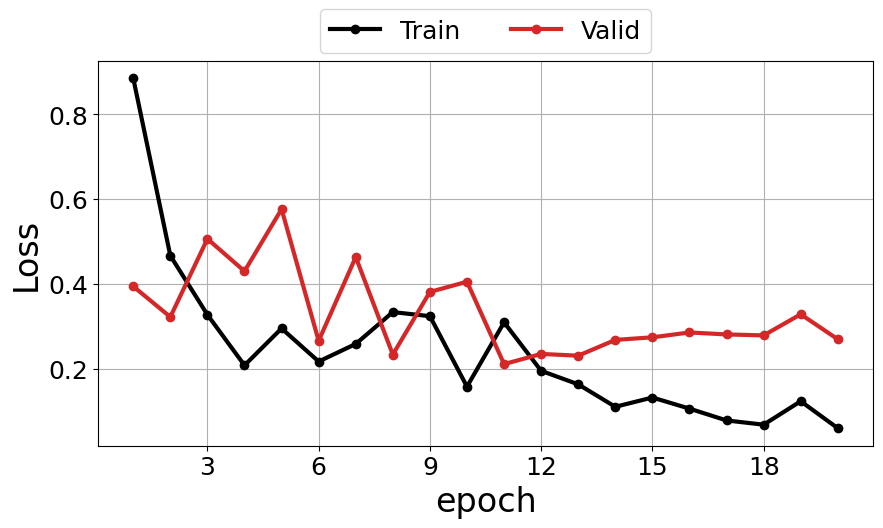

In [227]:
my_classifier.plot_metric(y_axis=["epoch_loss_train", "epoch_loss_val"],
                         y_label="Loss",
                         legends=["Train", "Valid"])

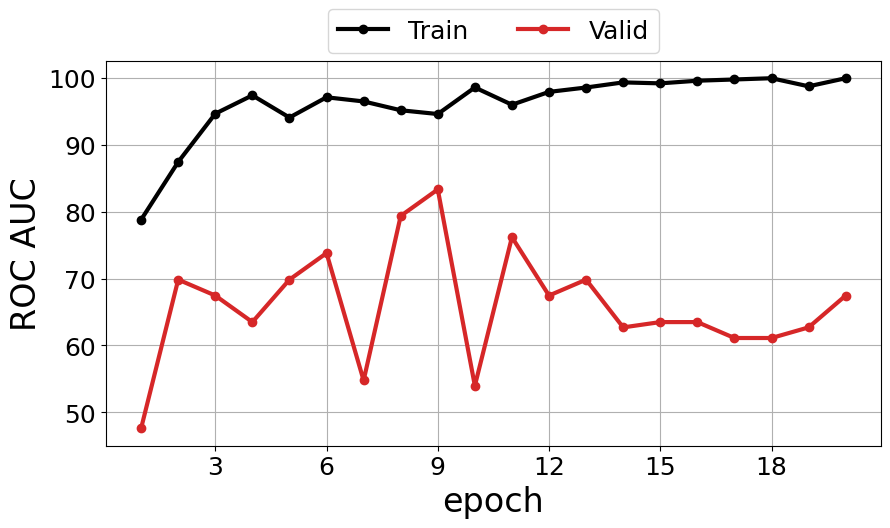

In [228]:
my_classifier.plot_metric(y_axis=["epoch_rocauc_macro_train", "epoch_rocauc_macro_val"],
                         y_label="ROC AUC",
                         legends=["Train", "Valid"],
                         colors=["k", "tab:red"])

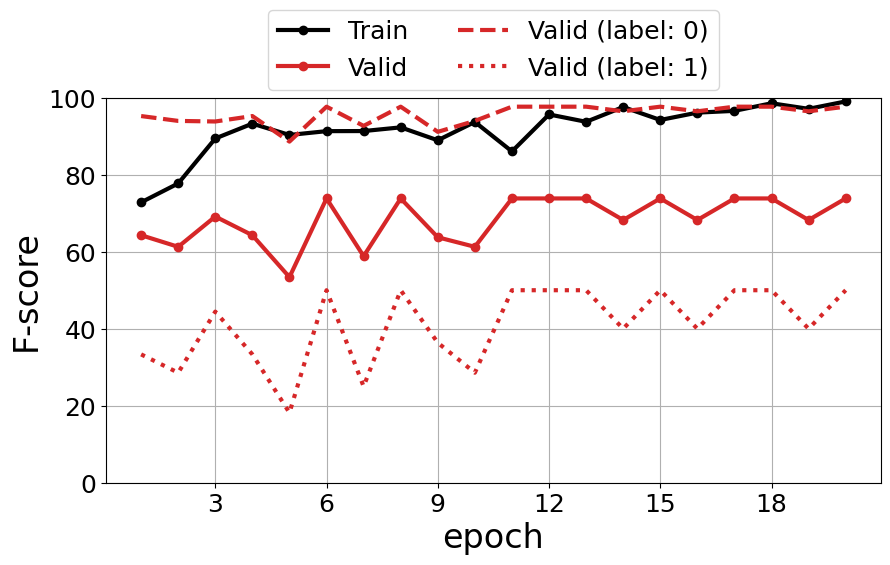

In [229]:
my_classifier.plot_metric(y_axis=["epoch_fscore_macro_train", 
                                 "epoch_fscore_macro_val", 
                                 "epoch_fscore_0_val", 
                                 "epoch_fscore_1_val"],
                         y_label="F-score",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

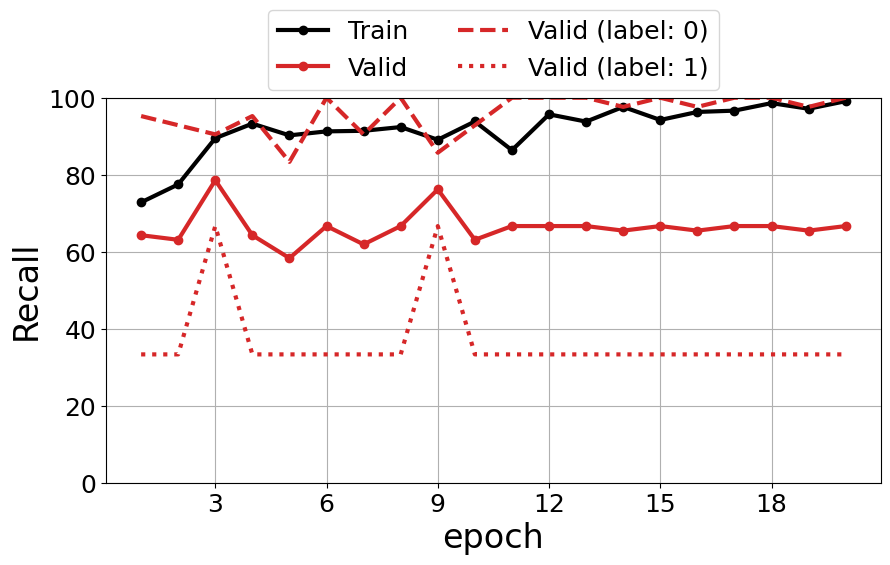

In [230]:
my_classifier.plot_metric(y_axis=["epoch_recall_macro_train", 
                                 "epoch_recall_macro_val", 
                                 "epoch_recall_0_val", 
                                 "epoch_recall_1_val"],
                         y_label="Recall",
                         legends=["Train", 
                                  "Valid", 
                                  "Valid (label: 0)",
                                  "Valid (label: 1)",],
                         colors=["k", "tab:red", "tab:red", "tab:red"],
                         styles=["-", "-", "--", ":"],
                         markers=["o", "o", "", ""],
                         plt_yrange=[0, 100])

## Model inference on test set

Refer to the next notebook for details on model inference. Here, we use the test dataset (defined above) and run the trained model on that set.

In [240]:
# Add test dataset
my_classifier.add2dataloader(test_dataset, 
                            set_name="test", 
                            batch_size=batch_size)

[INFO] added 'test' dataloader with 45 elements.


In [242]:
my_classifier.inference(set_name="test")

2023-02-07 14:41:40 JY5FK6W3K5 [INFO] test     -- 21/21 --        8/45 ( 17.8%) -- 
2023-02-07 14:41:40 JY5FK6W3K5 [INFO] test     -- 21/21 --       45/45 (100.0%) -- 
Total time: 0m 1s


In [ ]:
my_c

In [234]:
# Calculate metrics using inference outputs
my_classifier.calculate_add_metrics(my_classifier.orig_label, 
                                   my_classifier.pred_label,
                                   my_classifier.pred_conf,
                                   "test")

In [246]:
# list of calculated metrics (for test set):
[k for k in my_classifier.metrics if "test" in k]

['epoch_prec_micro_test',
 'epoch_recall_micro_test',
 'epoch_fscore_micro_test',
 'epoch_supp_micro_test',
 'epoch_rocauc_micro_test',
 'epoch_prec_macro_test',
 'epoch_recall_macro_test',
 'epoch_fscore_macro_test',
 'epoch_supp_macro_test',
 'epoch_rocauc_macro_test',
 'epoch_prec_weighted_test',
 'epoch_recall_weighted_test',
 'epoch_fscore_weighted_test',
 'epoch_supp_weighted_test',
 'epoch_rocauc_weighted_test',
 'epoch_prec_0_test',
 'epoch_recall_0_test',
 'epoch_fscore_0_test',
 'epoch_supp_0_test',
 'epoch_prec_1_test',
 'epoch_recall_1_test',
 'epoch_fscore_1_test',
 'epoch_supp_1_test']

In [243]:
print(my_classifier.metrics["epoch_fscore_micro_test"])
print(my_classifier.metrics["epoch_rocauc_weighted_test"])

[91.11111111111111]
[86.5079365079365]


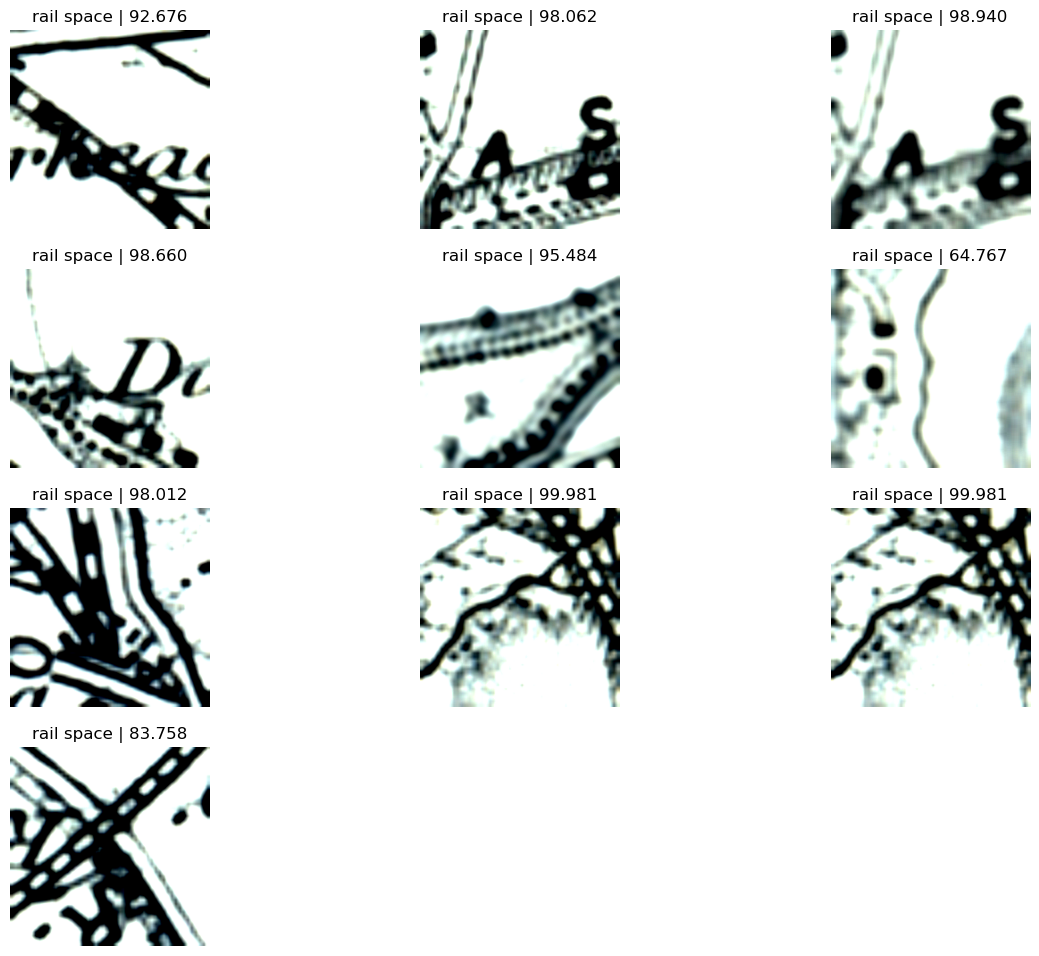

In [244]:
my_classifier.inference_sample_results(class_index=1, num_samples=10)

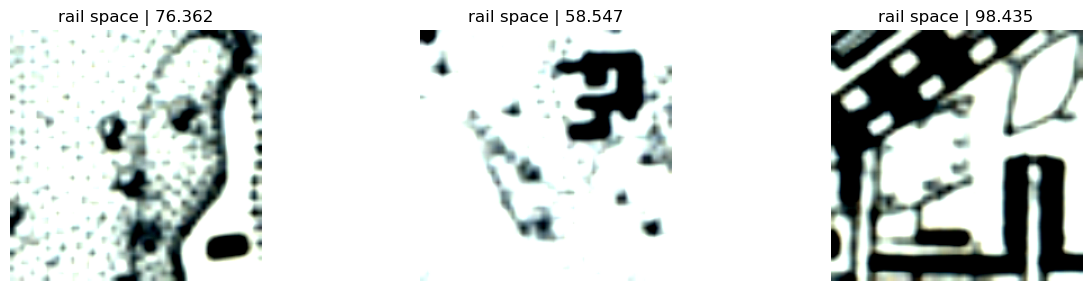

In [245]:
my_classifier.inference_sample_results(num_samples=8, 
                                      class_index=1, 
                                      set_name="test",
                                      min_conf=50,
                                      max_conf=None)